In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_data_csv(filename):
    data = pd.read_csv(f"data/{filename}",sep=";")
    data.index = data["Phone timestamp"]
    data =data.drop(columns=["Phone timestamp","sensor timestamp [ns]"])
    data.index = pd.to_datetime(data.index)
    return data

In [3]:
def plot_with_markers(data,markers):
    fig, ax = plt.subplots(figsize=(15,7))
    for col in data.columns:
        ax.plot(data[col],label=col)
    for i,(start,end) in enumerate(markers):
        ax.axvspan(start,end,color='r',alpha=0.2,label="Marker" if i == 0 else "")
    
    ax.legend()
    plt.show()

In [4]:
data_passe_avant = read_data_csv("Passe_avant.csv")
markers_passe_avant = [
    (data_passe_avant.index[20],data_passe_avant.index[60]),
    (data_passe_avant.index[150],data_passe_avant.index[200]),
    (data_passe_avant.index[275],data_passe_avant.index[325]),
    (data_passe_avant.index[500],data_passe_avant.index[540]),
    (data_passe_avant.index[650],data_passe_avant.index[690]),
    (data_passe_avant.index[850],data_passe_avant.index[890]),
]

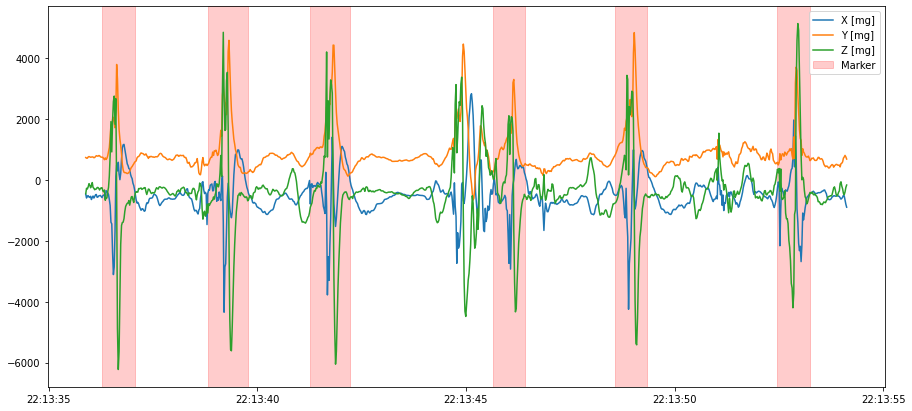

In [5]:
plot_with_markers(data_passe_avant,markers_passe_avant)

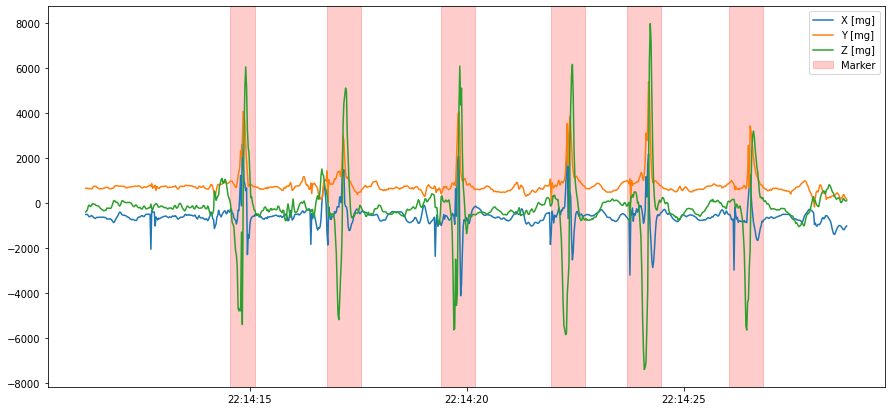

In [6]:
data_passe_backend = read_data_csv("Passe_backend.csv")
markers_passe_backend = [
    (data_passe_backend.index[170],data_passe_backend.index[200]),
    (data_passe_backend.index[285],data_passe_backend.index[325]),
    (data_passe_backend.index[420],data_passe_backend.index[460]),
    (data_passe_backend.index[550],data_passe_backend.index[590]),
    (data_passe_backend.index[640],data_passe_backend.index[680]),
    (data_passe_backend.index[760],data_passe_backend.index[800]),
]
plot_with_markers(data_passe_backend,markers_passe_backend)

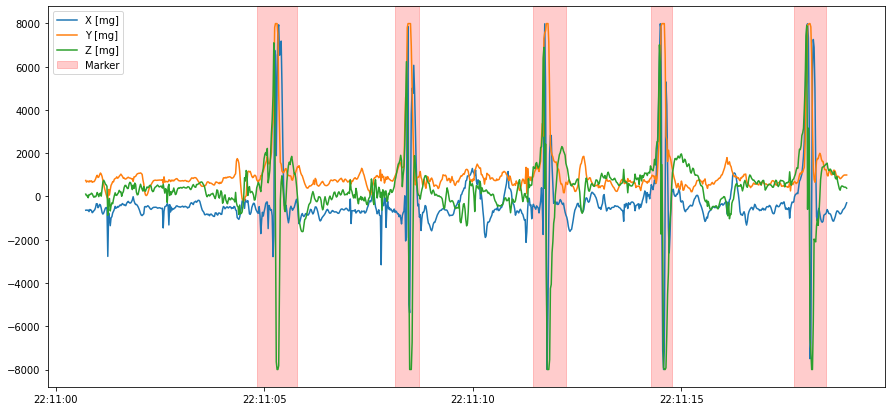

In [7]:
data_tir_avant = read_data_csv("Tir_avant.csv")
markers_tir_avant = [
    (data_tir_avant.index[210],data_tir_avant.index[260]),
    (data_tir_avant.index[380],data_tir_avant.index[410]),
    (data_tir_avant.index[550],data_tir_avant.index[590]),
    (data_tir_avant.index[695],data_tir_avant.index[720]),
    (data_tir_avant.index[870],data_tir_avant.index[910]),
]
plot_with_markers(data_tir_avant,markers_tir_avant)

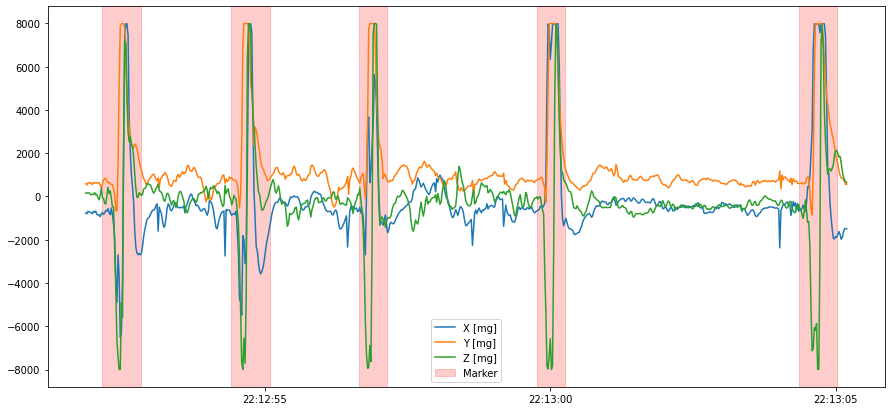

In [8]:
data_tir_backend = read_data_csv("Tir_backend.csv")
markers_tir_backend = [
    (data_tir_backend.index[15],data_tir_backend.index[50]),
    (data_tir_backend.index[130],data_tir_backend.index[165]),
    (data_tir_backend.index[245],data_tir_backend.index[270]),
    (data_tir_backend.index[405],data_tir_backend.index[430]),
    (data_tir_backend.index[640],data_tir_backend.index[-10]),
]
plot_with_markers(data_tir_backend,markers_tir_backend)

In [9]:
def add_column_classification(data,markers):
    y = np.zeros(len(data))
    for (start,end,label) in markers:
        y[np.argwhere((data.index > start) & (data.index < end))] = label
    return y

In [10]:
def concatenate_data(data_tir,data_passe,markers_tir,markers_passe):
    first_pass_timestamp = data_passe.index[0]
    last_shoot_timestamp = data_tir.index[-1]

    data_passe.index -= first_pass_timestamp
    data_passe.index += last_shoot_timestamp
    data = pd.concat((data_tir,data_passe))
    markers = []
    
    for (start,end) in markers_tir:
        markers.append((start,end,1))

    for (start,end) in markers_passe:
        start -= first_pass_timestamp
        start += last_shoot_timestamp
        end -= first_pass_timestamp
        end += last_shoot_timestamp
        markers.append((start,end,2))

    return data, markers

In [28]:
def concatenate_data_bis(data1,data2,markers1,markers2):
    first_timestamp = data2.index[0]
    last_timestamp = data1.index[-1]

    data2.index -= first_timestamp
    data2.index += last_timestamp
    data = pd.concat((data1,data2))

    markers = markers1.copy()

    for (start,end,label) in markers2:
        start -= first_timestamp
        start += last_timestamp
        end -= first_timestamp
        end += last_timestamp
        markers.append((start,end,label))

    return data, markers

In [12]:
def plot_with_markers_label(data,markers):
    fig, ax = plt.subplots(figsize=(15,7))
    for col in data.columns:
        ax.plot(data[col],label=col)
    for i,(start,end,label) in enumerate(markers):
        ax.axvspan(start,end,color='r'if label==1 else 'g',alpha=0.2)
    
    ax.legend()
    plt.show()

In [29]:
data_backend,markers_backend = concatenate_data(data_tir_backend.copy(),data_passe_backend.copy(),markers_tir_backend,markers_passe_backend)
data_avant,markers_avant = concatenate_data(data_tir_avant.copy(),data_passe_avant.copy(),markers_tir_avant,markers_passe_avant)

In [14]:
#data,markers = concatenate_data(data_tir_backend.copy(),data_passe_backend.copy(),markers_tir_backend,markers_passe_backend)
#plot_with_markers_label(data,markers)

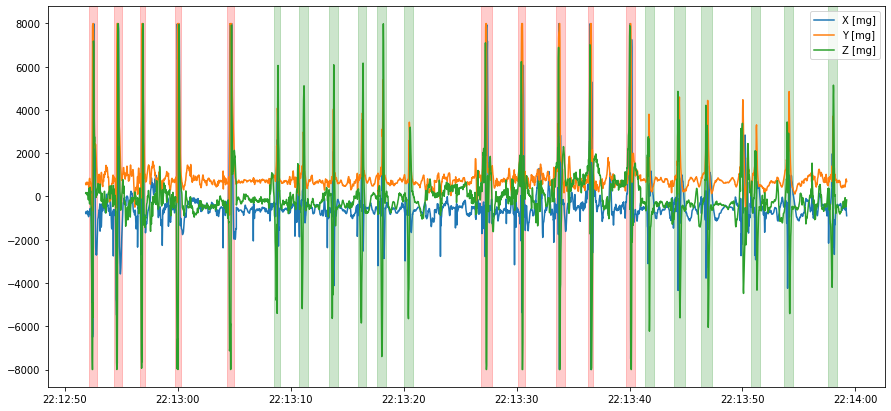

In [30]:
data,markers = concatenate_data_bis(data_backend.copy(),data_avant.copy(),markers_backend,markers_avant)
plot_with_markers_label(data,markers)

In [31]:
y_real = add_column_classification(data,markers)
y_real.shape

(3456,)

In [32]:
freq_sampling = 50

In [73]:
def compute_features(block):
    norms = np.linalg.norm(block,axis=1)
    return np.array([np.abs(np.max(norms)-np.min(norms)),np.max(norms),np.quantile(norms,0.25)])

In [19]:
def get_label(y):
    uniques,counts = np.unique(y,return_counts=True)
    return uniques[np.argmax(counts)]
    

In [20]:
def window_slide(data:pd.DataFrame,y,window_size):
    dataset = data.values
    n = len(data)//window_size
    features_extracted = []
    y_block = np.zeros(n)
    for i in range(n):
        block = dataset[i*window_size:(i+1)*window_size]
        features = compute_features(block)
        features_extracted.append(features)
        y_block[i] = get_label(y[i*window_size:(i+1)*window_size])
    return np.array(features_extracted),y_block

In [21]:
def box_plot(data,y,window_size,labels=['idk','shoot','pass']):
    dataset = data.values
    n = len(data)//window_size
    features_extracted = []
    blocks = {u:[] for u in np.unique(y)}
    for i in range(n):
        block = dataset[i*window_size:(i+1)*window_size]
        blocks[y[i]].append(block)
    
    data_box = []
    for label in blocks.keys():
        norms = []
        for block in blocks[label]:
            norms.append(np.linalg.norm(block,axis=1))
        
        norms = np.concatenate(norms)
        data_box.append(norms)

    fig,ax = plt.subplots(figsize=(10,7))
    ax.boxplot(data_box)
    ax.set_xticks(np.arange(1,len(blocks.keys())+1))
    ax.set_xticklabels(labels)
    plt.show()

In [74]:
markers_timedelta_max=np.max([end-start for (start,end,_) in markers])//(1.8)
window_size=int(markers_timedelta_max.total_seconds()*freq_sampling)
window_size

27

In [23]:
def plot_data_y(data,y,window_size):
    fig,ax = plt.subplots(figsize=(15,7))
    ax.plot(data.values)
    for i in range(len(y)):
        if y[i]!=0:
            ax.axvspan(i*window_size,(i+1)*window_size,color='r'if y[i]==1 else 'g',alpha=0.2)
    

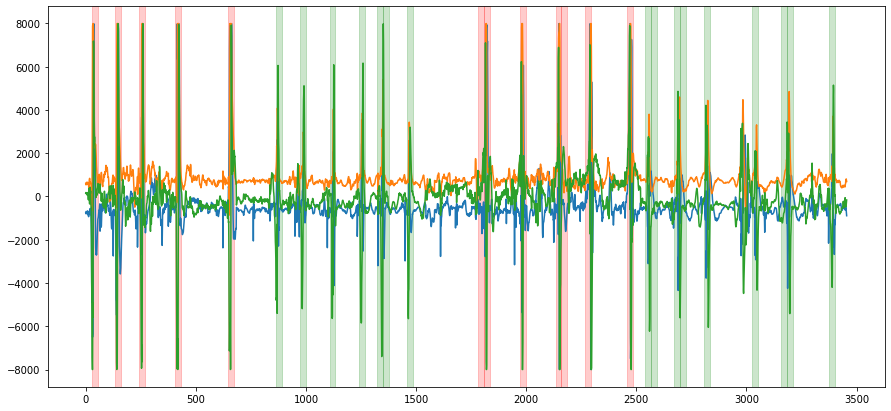

In [75]:
X,y = window_slide(data,y_real,window_size)
y.shape
plot_data_y(data,y,window_size)

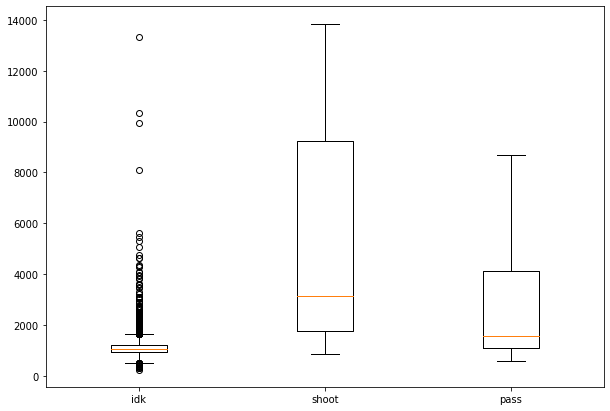

In [76]:
box_plot(data,y,window_size)

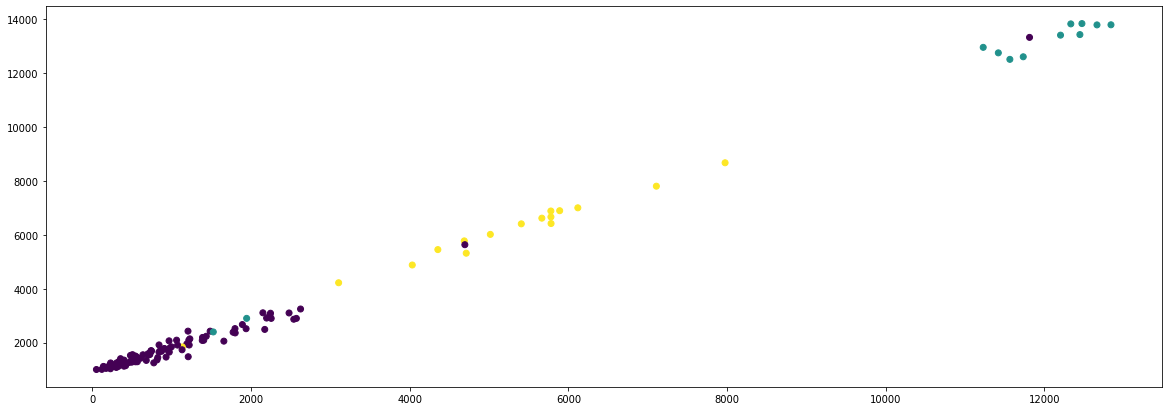

In [84]:
# Quick plot to see if we can separate the data for machine learning 
fig,ax = plt.subplots(figsize=(20,7))
ax.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [88]:
%matplotlib qt

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:,0],X[:,1],X[:,2],c=y)

plt.show()

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [69]:
X.shape

(128, 3)

In [79]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33)

In [80]:
clf = LogisticRegression()
clf.fit(X_train,y_train)

LogisticRegression()

<AxesSubplot:>

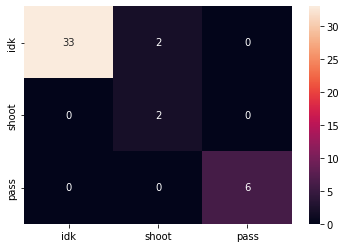

In [81]:
labels = ['idk','shoot','pass']
y_pred=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels)

<AxesSubplot:>

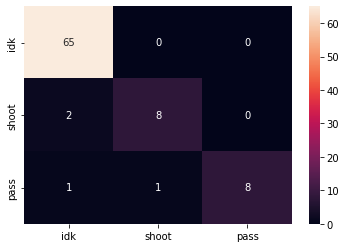

In [82]:
y_pred=clf.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels)